In [29]:
from tqdm import tqdm
import torchvision
from glob import glob
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torch.nn.functional as F
import time
%matplotlib inline
import joblib
from PIL import Image
import numpy as np

In [30]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '6, 7'

In [31]:
train_x = joblib.load('./train_celeba_x_exp_fake_2.pkl')
train_y = joblib.load('./train_celeba_y_exp_fake_2.pkl')

In [32]:
class TrainCelebA(Dataset):
    
    def __init__(self, x, y):
        
        self.x = torch.tensor(x).float()
        self.y = torch.tensor(y).float()
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):   
        sample = [self.x[index], int(torch.argmax(self.y[index]))]
        
        return sample


In [33]:
train_dl = TrainCelebA(train_x, train_y)

In [34]:
from torchvision.datasets import CelebA

class CelebA_Male(CelebA):
    def __getitem__(self, index):
        X = Image.open(os.path.join(self.root, self.base_folder, "img_align_celeba", self.filename[index]))

        target = []
        for t in self.target_type:
            if t == "attr":
                target.append(self.attr[index, 20:21]) # Male
            elif t == "identity":
                target.append(self.identity[index, 0])
            elif t == "bbox":
                target.append(self.bbox[index, :])
            elif t == "landmarks":
                target.append(self.landmarks_align[index, :])
            else:
                raise ValueError("Target type \"{}\" is not recognized.".format(t))
        target = tuple(target) if len(target) > 1 else target[0]

        if self.transform is not None:
            X = self.transform(X)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return X, target

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])
tmp_dl = CelebA_Male(root="/data/local/qipan/exp_celeba/datasets/celeba", download=False, transform=test_transform)

# val_num = tmp_dl.__len__()//100
# _, valid_dl = torch.utils.data.random_split(tmp_dl, [tmp_dl.__len__()-val_num, val_num])

valid_dl = tmp_dl

print(valid_dl.__len__())

162770


In [35]:
x, y = valid_dl[0]

In [36]:
x.shape, y

(torch.Size([3, 128, 128]), tensor([0]))

In [37]:
train_dataloader = torch.utils.data.DataLoader(train_dl, shuffle = True, batch_size = 4, num_workers = 4)
valid_dataloader = torch.utils.data.DataLoader(valid_dl, shuffle = True, batch_size = 4, num_workers = 4)

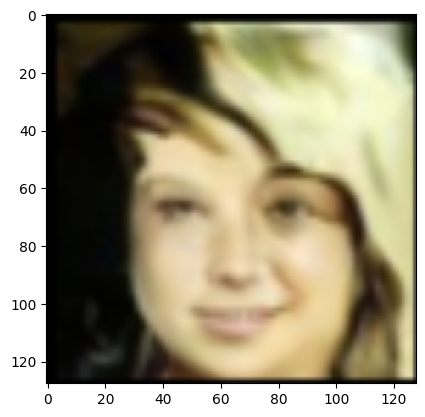

In [38]:
plt.imshow(torchvision.utils.make_grid(train_dl[6][0]).permute(1, 2, 0))

In [39]:
class MultiClassifier(nn.Module):
    def __init__(self):
        super(MultiClassifier, self).__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3), # 3, 256, 256
            nn.MaxPool2d(2), # op: 16, 127, 127
            nn.ReLU(), # op: 64, 127, 127
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3), # 64, 127, 127   
            nn.MaxPool2d(2), #op: 128, 63, 63
            nn.ReLU() # op: 128, 63, 63
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3), # 128, 63, 63
            nn.MaxPool2d(2), #op: 256, 30, 30
            nn.ReLU() #op: 256, 30, 30
        )
        
        self.Linear1 = nn.Linear(256*14*14, 64)
        self.Linear2 = nn.Linear(64, 2)
                
        
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)

        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.Linear2(x)
        return F.softmax(x)

In [40]:
def check_cuda():
    _cuda = False
    if torch.cuda.is_available():
        _cuda = True
    return _cuda

In [41]:
is_cuda = check_cuda()

In [42]:
model = MultiClassifier()
if is_cuda:
    model.cuda()

In [43]:
x = train_dl[0][0].unsqueeze(0).cuda()

In [44]:
model(x).shape

/tmp/ipykernel_1050114/3814926896.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


torch.Size([1, 2])

In [45]:
def pred_acc(original, predicted):
    return torch.round(predicted).eq(original).sum().numpy()/len(original)

In [46]:
criterion = nn.BCELoss()
# optimizer = optim.SGD(model.parameters(), lr = 0.0001, momentum = 0.9)
# optimizer = optim.SGD(model.parameters(), lr = 2e-2)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [47]:
from pprint import pprint

In [48]:
model.train()

MultiClassifier(
  (ConvLayer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (Linear1): Linear(in_features=50176, out_features=64, bias=True)
  (Linear2): Linear(in_features=64, out_features=2, bias=True)
)

In [49]:
def fit_model(epochs, model, dataloader, phase = 'training', volatile = False):
    
    pprint("Epoch: {}".format(epochs))

    if phase == 'training':
        model.train()
        
    if phase == 'validataion':
        model.eval()
        volatile = True
        
    running_loss = []
    running_acc = []
    b = 0
    for i, data in enumerate(dataloader):
        inputs, target = data[0].cuda(), torch.eye(2)[data[1]].squeeze().cuda() 
        inputs, target = Variable(inputs), Variable(target)
        
        if phase == 'training':
            optimizer.zero_grad()
            
        ops = model(inputs)
        
        acc_ = []
        for i, d in enumerate(ops):
           
            acc = pred_acc(torch.Tensor.cpu(target[i]), torch.Tensor.cpu(d))
            acc_.append(acc)

        loss = criterion(ops, target)
                
        running_loss.append(loss.item())
        running_acc.append(np.asarray(acc_).mean())
        b += 1
       
        if phase == 'training':
            
            loss.backward()
        
            optimizer.step()
            
    total_batch_loss = np.asarray(running_loss).mean()
    total_batch_acc = np.asarray(running_acc).mean()
    

    pprint("{} loss is {} ".format(phase,total_batch_loss))
    pprint("{} accuracy is {} ".format(phase, total_batch_acc))
    
    return total_batch_loss, total_batch_acc


In [50]:
inputs, target = next(iter(train_dataloader))

In [51]:
ops = model(inputs.cuda())

/tmp/ipykernel_1050114/3814926896.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


In [52]:
trn_losses = []; trn_acc = []
val_losses = []; val_acc = []


In [53]:
for i in tqdm(range(1, 100)):
    trn_l, trn_a = fit_model(i, model, train_dataloader)
    val_l, val_a = fit_model(i, model, valid_dataloader, phase = 'validation')
    trn_losses.append(trn_l); trn_acc.append(trn_a)
    val_losses.append(val_l); val_acc.append(val_a)


  0%|          | 0/99 [00:00<?, ?it/s]

'Epoch: 1'


/tmp/ipykernel_1050114/3814926896.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


'training loss is 0.659642273798171 '
'training accuracy is 0.6680555555555555 '
'Epoch: 1'


  1%|          | 1/99 [01:32<2:30:56, 92.41s/it]

'validation loss is 0.6863334713305475 '
'validation accuracy is 0.5806219742953334 '
'Epoch: 2'
'training loss is 0.6390379613748303 '
'training accuracy is 0.6796296296296296 '
'Epoch: 2'


  2%|▏         | 2/99 [03:03<2:28:05, 91.61s/it]

'validation loss is 0.7019086678913161 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 3'
'training loss is 0.6306663978982855 '
'training accuracy is 0.6800925925925926 '
'Epoch: 3'


  3%|▎         | 3/99 [04:34<2:26:24, 91.51s/it]

'validation loss is 0.6953672951301253 '
'validation accuracy is 0.5807632762391566 '
'Epoch: 4'
'training loss is 0.633651247786151 '
'training accuracy is 0.6805555555555556 '
'Epoch: 4'


  4%|▍         | 4/99 [06:04<2:23:55, 90.90s/it]

'validation loss is 0.6828226701706429 '
'validation accuracy is 0.5823544589978621 '
'Epoch: 5'
'training loss is 0.6254952407545513 '
'training accuracy is 0.6800925925925926 '
'Epoch: 5'


  5%|▌         | 5/99 [07:35<2:22:16, 90.81s/it]

'validation loss is 0.7235320683878966 '
'validation accuracy is 0.5817093849064949 '
'Epoch: 6'
'training loss is 0.6184745477857413 '
'training accuracy is 0.6833333333333333 '
'Epoch: 6'


  6%|▌         | 6/99 [09:05<2:20:24, 90.58s/it]

'validation loss is 0.7184844016065742 '
'validation accuracy is 0.5840808001376158 '
'Epoch: 7'
'training loss is 0.6150958294669787 '
'training accuracy is 0.6842592592592592 '
'Epoch: 7'


  7%|▋         | 7/99 [10:38<2:19:50, 91.20s/it]

'validation loss is 0.7179298594217197 '
'validation accuracy is 0.5822131570540388 '
'Epoch: 8'
'training loss is 0.6163159554755246 '
'training accuracy is 0.6842592592592592 '
'Epoch: 8'


  8%|▊         | 8/99 [12:09<2:18:29, 91.31s/it]

'validation loss is 0.7294584223629582 '
'validation accuracy is 0.5836998992455705 '
'Epoch: 9'
'training loss is 0.624485347337193 '
'training accuracy is 0.6833333333333333 '
'Epoch: 9'


  9%|▉         | 9/99 [13:39<2:16:29, 90.99s/it]

'validation loss is 0.9499957839837369 '
'validation accuracy is 0.5810581672523529 '
'Epoch: 10'
'training loss is 0.6217506124741501 '
'training accuracy is 0.6833333333333333 '
'Epoch: 10'


 10%|█         | 10/99 [15:10<2:14:34, 90.73s/it]

'validation loss is 0.949683947032628 '
'validation accuracy is 0.5835401666134225 '
'Epoch: 11'
'training loss is 0.6173790412368598 '
'training accuracy is 0.6819444444444445 '
'Epoch: 11'


 11%|█         | 11/99 [16:42<2:13:39, 91.13s/it]

'validation loss is 0.7290669916424188 '
'validation accuracy is 0.5811134593173273 '
'Epoch: 12'
'training loss is 0.618778946802572 '
'training accuracy is 0.6847222222222222 '
'Epoch: 12'


 12%|█▏        | 12/99 [18:14<2:12:30, 91.38s/it]

'validation loss is 0.7429015945006117 '
'validation accuracy is 0.5816909542181702 '
'Epoch: 13'
'training loss is 0.6153641063306067 '
'training accuracy is 0.6847222222222222 '
'Epoch: 13'


 13%|█▎        | 13/99 [19:44<2:10:43, 91.20s/it]

'validation loss is 0.762678146119158 '
'validation accuracy is 0.5815005037721476 '
'Epoch: 14'
'training loss is 0.6147509035964807 '
'training accuracy is 0.6851851851851852 '
'Epoch: 14'


 14%|█▍        | 14/99 [21:16<2:09:24, 91.34s/it]

'validation loss is 0.9377588581730405 '
'validation accuracy is 0.5817339591575946 '
'Epoch: 15'
'training loss is 0.6156297542154789 '
'training accuracy is 0.6847222222222222 '
'Epoch: 15'


 15%|█▌        | 15/99 [22:45<2:07:01, 90.73s/it]

'validation loss is 1.085881036011227 '
'validation accuracy is 0.583742904184995 '
'Epoch: 16'
'training loss is 0.6473123378775738 '
'training accuracy is 0.6833333333333333 '
'Epoch: 16'


 16%|█▌        | 16/99 [24:18<2:06:21, 91.34s/it]

'validation loss is 0.7938543948536058 '
'validation accuracy is 0.580486815914285 '
'Epoch: 17'
'training loss is 0.6159529586908994 '
'training accuracy is 0.6837962962962963 '
'Epoch: 17'


 17%|█▋        | 17/99 [25:50<2:05:00, 91.47s/it]

'validation loss is 0.8537949986719778 '
'validation accuracy is 0.5805912564814587 '
'Epoch: 18'
'training loss is 0.6158025123454907 '
'training accuracy is 0.6842592592592592 '
'Epoch: 18'


 18%|█▊        | 18/99 [27:19<2:02:23, 90.66s/it]

'validation loss is 0.7972907611858882 '
'validation accuracy is 0.5810827415034527 '
'Epoch: 19'
'training loss is 0.7099536392423842 '
'training accuracy is 0.6833333333333333 '
'Epoch: 19'


 19%|█▉        | 19/99 [28:49<2:00:41, 90.52s/it]

'validation loss is 0.7773613536978636 '
'validation accuracy is 0.5806035436070086 '
'Epoch: 20'
'training loss is 0.6206619739532471 '
'training accuracy is 0.6842592592592592 '
'Epoch: 20'


 20%|██        | 20/99 [30:23<2:00:34, 91.58s/it]

'validation loss is 0.7307976972078933 '
'validation accuracy is 0.5808492861180056 '
'Epoch: 21'
'training loss is 0.6145901918963149 '
'training accuracy is 0.6847222222222222 '
'Epoch: 21'


 21%|██        | 21/99 [31:55<1:59:14, 91.72s/it]

'validation loss is 0.735684625019507 '
'validation accuracy is 0.5809537266851793 '
'Epoch: 22'
'training loss is 0.614346754109418 '
'training accuracy is 0.6851851851851852 '
'Epoch: 22'


 22%|██▏       | 22/99 [33:25<1:57:01, 91.18s/it]

'validation loss is 0.7457541325101075 '
'validation accuracy is 0.580972157373504 '
'Epoch: 23'
'training loss is 0.6139881030276969 '
'training accuracy is 0.6851851851851852 '
'Epoch: 23'


 23%|██▎       | 23/99 [34:58<1:56:15, 91.78s/it]

'validation loss is 0.7527008278127548 '
'validation accuracy is 0.5809844444990538 '
'Epoch: 24'
'training loss is 0.6139710336371704 '
'training accuracy is 0.6851851851851852 '
'Epoch: 24'


 24%|██▍       | 24/99 [36:29<1:54:30, 91.60s/it]

'validation loss is 0.7683765252443928 '
'validation accuracy is 0.581138033568427 '
'Epoch: 25'
'training loss is 0.6139676163317981 '
'training accuracy is 0.6851851851851852 '
'Epoch: 25'


 25%|██▌       | 25/99 [38:00<1:52:44, 91.42s/it]

'validation loss is 0.7844104424473829 '
'validation accuracy is 0.5813407711399995 '
'Epoch: 26'
'training loss is 0.6136937681171629 '
'training accuracy is 0.6851851851851852 '
'Epoch: 26'


 26%|██▋       | 26/99 [39:31<1:51:05, 91.30s/it]

'validation loss is 0.8767649116443104 '
'validation accuracy is 0.5822623055562381 '
'Epoch: 27'
'training loss is 0.6138321546492753 '
'training accuracy is 0.6851851851851852 '
'Epoch: 27'


 27%|██▋       | 27/99 [41:03<1:49:38, 91.37s/it]

'validation loss is 0.800192286568914 '
'validation accuracy is 0.5817585334086943 '
'Epoch: 28'
'training loss is 0.6156917501930838 '
'training accuracy is 0.6810185185185185 '
'Epoch: 28'


 28%|██▊       | 28/99 [42:33<1:47:46, 91.08s/it]

'validation loss is 3.2222772124055536 '
'validation accuracy is 0.5807018406114074 '
'Epoch: 29'
'training loss is 1.0389514260821873 '
'training accuracy is 0.6805555555555556 '
'Epoch: 29'


 29%|██▉       | 29/99 [44:06<1:46:42, 91.47s/it]

'validation loss is 1.944734111135679 '
'validation accuracy is 0.5807202712997321 '
'Epoch: 30'
'training loss is 0.720799598870454 '
'training accuracy is 0.6800925925925926 '
'Epoch: 30'


 30%|███       | 30/99 [45:38<1:45:22, 91.63s/it]

'validation loss is 0.7037466912191024 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 31'
'training loss is 0.6278649170641546 '
'training accuracy is 0.6796296296296296 '
'Epoch: 31'


 31%|███▏      | 31/99 [47:10<1:43:58, 91.75s/it]

'validation loss is 0.6990592282639757 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 32'
'training loss is 0.627736502830629 '
'training accuracy is 0.6796296296296296 '
'Epoch: 32'


 32%|███▏      | 32/99 [48:39<1:41:39, 91.04s/it]

'validation loss is 0.6987483317734021 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 33'
'training loss is 0.6275217806299528 '
'training accuracy is 0.6796296296296296 '
'Epoch: 33'


 33%|███▎      | 33/99 [50:11<1:40:24, 91.28s/it]

'validation loss is 0.7096874050312119 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 34'
'training loss is 0.6279025750027762 '
'training accuracy is 0.6796296296296296 '
'Epoch: 34'


 34%|███▍      | 34/99 [51:43<1:39:09, 91.53s/it]

'validation loss is 0.7030954589475925 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 35'
'training loss is 0.6277324454100044 '
'training accuracy is 0.6796296296296296 '
'Epoch: 35'


 35%|███▌      | 35/99 [53:14<1:37:31, 91.44s/it]

'validation loss is 0.7049383834504976 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 36'
'training loss is 0.6278563139063341 '
'training accuracy is 0.6796296296296296 '
'Epoch: 36'


 36%|███▋      | 36/99 [54:45<1:35:50, 91.28s/it]

'validation loss is 0.7061194201186949 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 37'
'training loss is 0.6277396440505981 '
'training accuracy is 0.6796296296296296 '
'Epoch: 37'


 37%|███▋      | 37/99 [56:16<1:34:06, 91.07s/it]

'validation loss is 0.706712722926259 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 38'
'training loss is 0.6281078509158559 '
'training accuracy is 0.6796296296296296 '
'Epoch: 38'


 38%|███▊      | 38/99 [57:47<1:32:40, 91.15s/it]

'validation loss is 0.7034116327019981 '
'validation accuracy is 0.5806219742953334 '
'Epoch: 39'
'training loss is 0.6276482361886236 '
'training accuracy is 0.6796296296296296 '
'Epoch: 39'


 39%|███▉      | 39/99 [59:20<1:31:43, 91.73s/it]

'validation loss is 0.7011501321526196 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 40'
'training loss is 0.6276913772578593 '
'training accuracy is 0.6796296296296296 '
'Epoch: 40'


 40%|████      | 40/99 [1:00:52<1:30:22, 91.91s/it]

'validation loss is 0.6948781472406305 '
'validation accuracy is 0.5806219742953334 '
'Epoch: 41'
'training loss is 0.6277959683978999 '
'training accuracy is 0.6796296296296296 '
'Epoch: 41'


 41%|████▏     | 41/99 [1:02:25<1:28:54, 91.98s/it]

'validation loss is 0.7051392988033652 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 42'
'training loss is 0.6278409944088371 '
'training accuracy is 0.6796296296296296 '
'Epoch: 42'


 42%|████▏     | 42/99 [1:03:57<1:27:26, 92.04s/it]

'validation loss is 0.7038831950439489 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 43'
'training loss is 0.6278172713738901 '
'training accuracy is 0.6796296296296296 '
'Epoch: 43'


 43%|████▎     | 43/99 [1:05:28<1:25:43, 91.84s/it]

'validation loss is 0.7030124531549975 '
'validation accuracy is 0.5806219742953334 '
'Epoch: 44'
'training loss is 0.6277733574310939 '
'training accuracy is 0.6796296296296296 '
'Epoch: 44'


 44%|████▍     | 44/99 [1:06:59<1:23:51, 91.49s/it]

'validation loss is 0.6951753110600933 '
'validation accuracy is 0.5806219742953334 '
'Epoch: 45'
'training loss is 0.6278800897576191 '
'training accuracy is 0.6796296296296296 '
'Epoch: 45'


 45%|████▌     | 45/99 [1:08:31<1:22:34, 91.74s/it]

'validation loss is 0.7034517013506366 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 46'
'training loss is 0.627657607584088 '
'training accuracy is 0.6796296296296296 '
'Epoch: 46'


 46%|████▋     | 46/99 [1:10:02<1:20:55, 91.61s/it]

'validation loss is 0.7080192104305313 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 47'
'training loss is 0.6276341742387525 '
'training accuracy is 0.6796296296296296 '
'Epoch: 47'


 47%|████▋     | 47/99 [1:11:32<1:18:56, 91.08s/it]

'validation loss is 0.697098067205759 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 48'
'training loss is 0.6275741755962372 '
'training accuracy is 0.6796296296296296 '
'Epoch: 48'


 48%|████▊     | 48/99 [1:13:03<1:17:18, 90.96s/it]

'validation loss is 0.7069020365513314 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 49'
'training loss is 0.6276875882237046 '
'training accuracy is 0.6796296296296296 '
'Epoch: 49'


 49%|████▉     | 49/99 [1:14:34<1:15:47, 90.95s/it]

'validation loss is 0.7003737569398704 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 50'
'training loss is 0.6276942446827889 '
'training accuracy is 0.6796296296296296 '
'Epoch: 50'


 51%|█████     | 50/99 [1:16:06<1:14:40, 91.43s/it]

'validation loss is 0.7010510759986347 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 51'
'training loss is 0.6277432621077255 '
'training accuracy is 0.6796296296296296 '
'Epoch: 51'


 52%|█████▏    | 51/99 [1:17:37<1:13:03, 91.32s/it]

'validation loss is 0.7031768723852504 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 52'
'training loss is 0.6275427890596567 '
'training accuracy is 0.6796296296296296 '
'Epoch: 52'


 53%|█████▎    | 52/99 [1:19:08<1:11:24, 91.17s/it]

'validation loss is 0.7045472476633142 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 53'
'training loss is 0.6275105017754766 '
'training accuracy is 0.6796296296296296 '
'Epoch: 53'


 54%|█████▎    | 53/99 [1:20:42<1:10:24, 91.84s/it]

'validation loss is 0.7084302157965565 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 54'
'training loss is 0.6279912235008346 '
'training accuracy is 0.6796296296296296 '
'Epoch: 54'


 55%|█████▍    | 54/99 [1:22:12<1:08:30, 91.35s/it]

'validation loss is 0.7010045454143713 '
'validation accuracy is 0.5806219742953334 '
'Epoch: 55'
'training loss is 0.6275601217592204 '
'training accuracy is 0.6796296296296296 '
'Epoch: 55'


 56%|█████▌    | 55/99 [1:23:44<1:07:08, 91.56s/it]

'validation loss is 0.699877625859367 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 56'
'training loss is 0.6273919746831611 '
'training accuracy is 0.6796296296296296 '
'Epoch: 56'


 57%|█████▋    | 56/99 [1:25:14<1:05:19, 91.15s/it]

'validation loss is 0.6979584171575259 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 57'
'training loss is 0.6275840261468181 '
'training accuracy is 0.6796296296296296 '
'Epoch: 57'


 58%|█████▊    | 57/99 [1:26:46<1:03:58, 91.39s/it]

'validation loss is 0.6992826873955043 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 58'
'training loss is 0.6274594251756315 '
'training accuracy is 0.6796296296296296 '
'Epoch: 58'


 59%|█████▊    | 58/99 [1:28:18<1:02:32, 91.52s/it]

'validation loss is 0.6970959714191209 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 59'
'training loss is 0.6276756267304774 '
'training accuracy is 0.6796296296296296 '
'Epoch: 59'


 60%|█████▉    | 59/99 [1:29:50<1:01:13, 91.83s/it]

'validation loss is 0.6984540701814755 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 60'
'training loss is 0.6276852631458529 '
'training accuracy is 0.6796296296296296 '
'Epoch: 60'


 61%|██████    | 60/99 [1:31:22<59:38, 91.76s/it]  

'validation loss is 0.7004227509083899 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 61'
'training loss is 0.6276517535249392 '
'training accuracy is 0.6796296296296296 '
'Epoch: 61'


 62%|██████▏   | 61/99 [1:32:55<58:18, 92.06s/it]

'validation loss is 0.6991530635458674 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 62'
'training loss is 0.6275367394089699 '
'training accuracy is 0.6796296296296296 '
'Epoch: 62'


 63%|██████▎   | 62/99 [1:34:25<56:27, 91.54s/it]

'validation loss is 0.7028522274527157 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 63'
'training loss is 0.6277045146734627 '
'training accuracy is 0.6796296296296296 '
'Epoch: 63'


 64%|██████▎   | 63/99 [1:35:57<54:54, 91.51s/it]

'validation loss is 0.7002840026749141 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 64'
'training loss is 0.627521027845365 '
'training accuracy is 0.6796296296296296 '
'Epoch: 64'


 65%|██████▍   | 64/99 [1:37:29<53:28, 91.66s/it]

'validation loss is 0.6999217498312127 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 65'
'training loss is 0.6275135230135035 '
'training accuracy is 0.6796296296296296 '
'Epoch: 65'


 66%|██████▌   | 65/99 [1:39:01<52:08, 92.02s/it]

'validation loss is 0.701563597835004 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 66'
'training loss is 0.6275646461380853 '
'training accuracy is 0.6796296296296296 '
'Epoch: 66'


 67%|██████▋   | 66/99 [1:40:34<50:40, 92.12s/it]

'validation loss is 0.6998713868402507 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 67'
'training loss is 0.6274661116026066 '
'training accuracy is 0.6796296296296296 '
'Epoch: 67'


 68%|██████▊   | 67/99 [1:42:06<49:12, 92.25s/it]

'validation loss is 0.6989726432881158 '
'validation accuracy is 0.5806219742953334 '
'Epoch: 68'
'training loss is 0.627400466689357 '
'training accuracy is 0.6796296296296296 '
'Epoch: 68'


 69%|██████▊   | 68/99 [1:43:38<47:34, 92.07s/it]

'validation loss is 0.7071362455415933 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 69'
'training loss is 0.6272640370660358 '
'training accuracy is 0.6796296296296296 '
'Epoch: 69'


 70%|██████▉   | 69/99 [1:45:10<45:57, 91.93s/it]

'validation loss is 0.6972578559469509 '
'validation accuracy is 0.5806219742953334 '
'Epoch: 70'
'training loss is 0.6275478048457039 '
'training accuracy is 0.6796296296296296 '
'Epoch: 70'


 71%|███████   | 70/99 [1:46:43<44:35, 92.25s/it]

'validation loss is 0.6997555789848962 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 71'
'training loss is 0.6275672924739343 '
'training accuracy is 0.6796296296296296 '
'Epoch: 71'


 72%|███████▏  | 71/99 [1:48:14<42:54, 91.95s/it]

'validation loss is 0.6996154714438627 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 72'
'training loss is 0.62744506481621 '
'training accuracy is 0.6796296296296296 '
'Epoch: 72'


 73%|███████▎  | 72/99 [1:49:46<41:24, 92.01s/it]

'validation loss is 0.7006165377563718 '
'validation accuracy is 0.5806219742953334 '
'Epoch: 73'
'training loss is 0.6275067246070615 '
'training accuracy is 0.6796296296296296 '
'Epoch: 73'


 74%|███████▎  | 73/99 [1:51:17<39:42, 91.65s/it]

'validation loss is 0.7001437446340932 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 74'
'training loss is 0.6274369990384138 '
'training accuracy is 0.6796296296296296 '
'Epoch: 74'


 75%|███████▍  | 74/99 [1:52:47<38:01, 91.25s/it]

'validation loss is 0.7000794973429191 '
'validation accuracy is 0.5806219742953334 '
'Epoch: 75'
'training loss is 0.6276008360915714 '
'training accuracy is 0.6796296296296296 '
'Epoch: 75'


 76%|███████▌  | 75/99 [1:54:20<36:40, 91.70s/it]

'validation loss is 0.703930166942508 '
'validation accuracy is 0.5806219742953334 '
'Epoch: 76'
'training loss is 0.6276443816997387 '
'training accuracy is 0.6796296296296296 '
'Epoch: 76'


 77%|███████▋  | 76/99 [1:55:48<34:46, 90.72s/it]

'validation loss is 0.698423115949856 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 77'
'training loss is 0.6276941315443427 '
'training accuracy is 0.6796296296296296 '
'Epoch: 77'


 78%|███████▊  | 77/99 [1:57:20<33:25, 91.15s/it]

'validation loss is 0.6992088291413504 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 78'
'training loss is 0.6276015143151636 '
'training accuracy is 0.6796296296296296 '
'Epoch: 78'


 79%|███████▉  | 78/99 [1:58:52<31:58, 91.35s/it]

'validation loss is 0.698395702392035 '
'validation accuracy is 0.5806219742953334 '
'Epoch: 79'
'training loss is 0.6273499667644501 '
'training accuracy is 0.6796296296296296 '
'Epoch: 79'


 80%|███████▉  | 79/99 [2:00:24<30:29, 91.46s/it]

'validation loss is 0.7021387252502834 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 80'
'training loss is 0.6276661080342752 '
'training accuracy is 0.6796296296296296 '
'Epoch: 80'


 81%|████████  | 80/99 [2:01:56<28:59, 91.57s/it]

'validation loss is 0.7001999660601729 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 81'
'training loss is 0.6274151585720203 '
'training accuracy is 0.6796296296296296 '
'Epoch: 81'


 82%|████████▏ | 81/99 [2:03:28<27:29, 91.64s/it]

'validation loss is 0.7102950297606755 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 82'
'training loss is 0.627588802465686 '
'training accuracy is 0.6796296296296296 '
'Epoch: 82'


 83%|████████▎ | 82/99 [2:04:58<25:53, 91.36s/it]

'validation loss is 0.7027336615917387 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 83'
'training loss is 0.6276046580186596 '
'training accuracy is 0.6796296296296296 '
'Epoch: 83'


 84%|████████▍ | 83/99 [2:06:31<24:26, 91.64s/it]

'validation loss is 0.7001603189804091 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 84'
'training loss is 0.6274582264048082 '
'training accuracy is 0.6796296296296296 '
'Epoch: 84'


 85%|████████▍ | 84/99 [2:08:02<22:53, 91.58s/it]

'validation loss is 0.7025322165187577 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 85'
'training loss is 0.6274842463157795 '
'training accuracy is 0.6796296296296296 '
'Epoch: 85'


 86%|████████▌ | 85/99 [2:09:33<21:20, 91.43s/it]

'validation loss is 0.7002270922939597 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 86'
'training loss is 0.6274127423763275 '
'training accuracy is 0.6796296296296296 '
'Epoch: 86'


 87%|████████▋ | 86/99 [2:11:06<19:53, 91.78s/it]

'validation loss is 0.7003004690362392 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 87'
'training loss is 0.6277244431553064 '
'training accuracy is 0.6796296296296296 '
'Epoch: 87'


 88%|████████▊ | 87/99 [2:12:37<18:18, 91.57s/it]

'validation loss is 0.700255997348417 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 88'
'training loss is 0.6275715846154425 '
'training accuracy is 0.6796296296296296 '
'Epoch: 88'


 89%|████████▉ | 88/99 [2:14:08<16:45, 91.41s/it]

'validation loss is 0.7027304240040361 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 89'
'training loss is 0.6273965754442745 '
'training accuracy is 0.6796296296296296 '
'Epoch: 89'


 90%|████████▉ | 89/99 [2:15:39<15:14, 91.44s/it]

'validation loss is 0.7041471147591134 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 90'
'training loss is 0.6275616210367945 '
'training accuracy is 0.6796296296296296 '
'Epoch: 90'


 91%|█████████ | 90/99 [2:17:12<13:45, 91.75s/it]

'validation loss is 0.7049948965794502 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 91'
'training loss is 0.6277561849466077 '
'training accuracy is 0.6796296296296296 '
'Epoch: 91'


 92%|█████████▏| 91/99 [2:18:42<12:10, 91.26s/it]

'validation loss is 0.703464211145154 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 92'
'training loss is 0.627529768369816 '
'training accuracy is 0.6796296296296296 '
'Epoch: 92'


 93%|█████████▎| 92/99 [2:20:16<10:43, 92.00s/it]

'validation loss is 0.701107806219559 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 93'
'training loss is 0.6274917017530512 '
'training accuracy is 0.6796296296296296 '
'Epoch: 93'


 94%|█████████▍| 93/99 [2:21:48<09:13, 92.19s/it]

'validation loss is 0.7028369428271131 '
'validation accuracy is 0.5806219742953334 '
'Epoch: 94'
'training loss is 0.6274959380427997 '
'training accuracy is 0.6796296296296296 '
'Epoch: 94'


 95%|█████████▍| 94/99 [2:23:20<07:39, 91.94s/it]

'validation loss is 0.7017463284922939 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 95'
'training loss is 0.6274530284934574 '
'training accuracy is 0.6796296296296296 '
'Epoch: 95'


 96%|█████████▌| 95/99 [2:24:53<06:09, 92.38s/it]

'validation loss is 0.7025978102380351 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 96'
'training loss is 0.6275204400773402 '
'training accuracy is 0.6796296296296296 '
'Epoch: 96'


 97%|█████████▋| 96/99 [2:26:25<04:36, 92.24s/it]

'validation loss is 0.7029940269458462 '
'validation accuracy is 0.5806342614208831 '
'Epoch: 97'
'training loss is 0.6274733345265742 '
'training accuracy is 0.6796296296296296 '
'Epoch: 97'


 98%|█████████▊| 97/99 [2:27:54<03:02, 91.41s/it]

'validation loss is 0.7014987426154152 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 98'
'training loss is 0.62733597876849 '
'training accuracy is 0.6796296296296296 '
'Epoch: 98'


 99%|█████████▉| 98/99 [2:29:25<01:31, 91.28s/it]

'validation loss is 0.7019851014834285 '
'validation accuracy is 0.5806281178581083 '
'Epoch: 99'
'training loss is 0.6272936307169773 '
'training accuracy is 0.6796296296296296 '
'Epoch: 99'


100%|██████████| 99/99 [2:30:58<00:00, 91.50s/it]

'validation loss is 0.7055211599910819 '
'validation accuracy is 0.5806342614208831 '


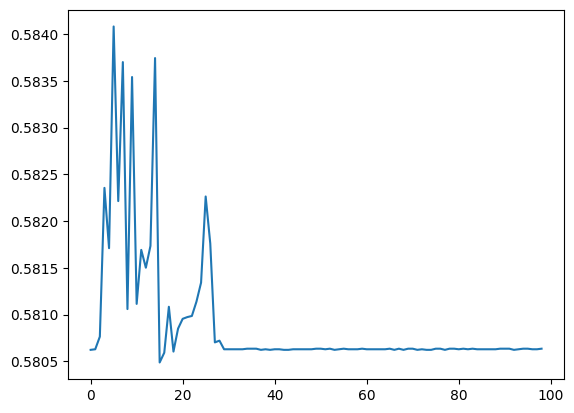

In [54]:
plt.plot(val_acc)

In [55]:
pred_y = model(train_dl[2][0].unsqueeze(0).cuda())

/tmp/ipykernel_1050114/3814926896.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


In [56]:
torch.round(pred_y).cpu().detach().numpy()

array([[1., 0.]], dtype=float32)